### TODO
1. [GCN Backprop](https://github.com/dmlc/dgl/issues/4021)
2. Visualize loss
3. [Embeddings](https://beta.openai.com/docs/guides/embeddings/what-are-embeddings)
4. Node embedding layer

In [1]:
import sys
import config
import argparse
import random
import visdom
import networkx as nx
import numpy as np
from collections import defaultdict
from pyvis.network import Network
import matplotlib.pyplot as plt
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

### Hyperparameters

In [2]:
seed = 0
epochs = 20000
lr = 0.001
hidden_dim = 16
hidden_dim2 = 20
np.random.seed(seed)

### Visualizations

In [3]:
def plot_in_visdom(data, title='', xlabel='', ylabel=''):
    vis = visdom.Visdom()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(data)
    vis.matplot(plt)
    
    vis.close()

### Graph data

In [4]:
G = nx.karate_club_graph()

In [5]:
num_nodes, num_edges = G.number_of_nodes(), G.number_of_edges()

### Generate labels from communities

In [6]:
communities = greedy_modularity_communities(G)
colors = np.zeros(G.number_of_nodes())
classes = set()

for i, c in enumerate(communities):
    colors[list(c)] = i
    classes.add(i)
    
num_classes = len(classes)
labels = (np.eye(len(classes))[colors.astype(int)]).T

classes, samples = labels.shape
print(f'labels.shape: {labels.shape}\t classes: {classes}\t samples: {samples}')

# each element after argmax represents the class and index represents the node.
print(np.argmax(labels, axis=0))

labels.shape: (3, 34)	 classes: 3	 samples: 34
[2 1 1 1 2 2 2 1 0 1 2 2 1 1 0 0 2 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


### Color nodes

In [7]:
def random_color():
    return '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# uncomment for random colors
# color_map = {cls: random_color() for cls in classes}
color_map = {0: '#46FB47', 1: '#B9E6B5', 2: '#9F9EBF'}

colored_graph = Network(width='100%', notebook=True)

for node in G.nodes():
    colored_graph.add_node(node, color=color_map[int(colors[node])])
    
for edge in G.edges():
    colored_graph.add_edge(int(edge[0]), int(edge[1]))
    
colored_graph.show('colored_graph.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


#### Renormalization trick

$A$ is the adjacency matrix, $I$ is the identity matrix, and $N$ is the cardinality of the set of nodes in the graph.

$$
\begin{align}
    \tilde{A} &= A + I_{N}\\
       \tilde{\mathcal{D}}_{ii} &= \sum_{i}\tilde{A}_{ij}\\
    \hat{\mathcal{A}}&=\tilde{\mathcal{D}}^{-\frac{1}{2}}\tilde{\mathcal{A}}\tilde{\mathcal{D}}^{-\frac{1}{2}}
\end{align}
$$

In this notebook, each column of the design matrix `A_hat` corresponds to a single node and each row is a feature dimension.

In [8]:
def renormalization(G):
    A = np.asarray(nx.to_numpy_matrix(G))
    I = np.eye(len(A))
    A_tilde = A + I
    D_tilde = np.zeros(A.shape, int)
    np.fill_diagonal(D_tilde, np.sum(A_tilde, axis=1).flatten())
    D_tilde = np.linalg.inv(D_tilde)
    D_tilde = np.power(D_tilde, 0.5)
    return D_tilde @ A_tilde @ D_tilde

In [9]:
nx.to_numpy_matrix(G)

matrix([[0., 4., 5., ..., 2., 0., 0.],
        [4., 0., 6., ..., 0., 0., 0.],
        [5., 6., 0., ..., 0., 2., 0.],
        ...,
        [2., 0., 0., ..., 0., 4., 4.],
        [0., 0., 2., ..., 4., 0., 5.],
        [0., 0., 0., ..., 4., 5., 0.]])

In [10]:
# Must pre-process offline
A_hat = renormalization(G)
print(A_hat)
print(A_hat.shape)

[[0.02325581 0.11136921 0.13076645 ... 0.06502561 0.         0.        ]
 [0.11136921 0.03333333 0.18786729 ... 0.         0.         0.        ]
 [0.13076645 0.18786729 0.02941176 ... 0.         0.0549235  0.        ]
 ...
 [0.06502561 0.         0.         ... 0.04545455 0.13655775 0.12182898]
 [0.         0.         0.0549235  ... 0.13655775 0.02564103 0.11437725]
 [0.         0.         0.         ... 0.12182898 0.11437725 0.02040816]]
(34, 34)


### Train-Test Split

In [11]:
train_split = 1
test_split = 1 - train_split
train_nodes = random.sample(list(range(34)), int(train_split * num_nodes))
test_nodes = list(set(range(34)) - set(train_nodes))

train_nodes.sort()
test_nodes.sort()
print(f'train_nodes ({len(train_nodes)}): {train_nodes}')
print(f'test_nodes  ({len(test_nodes)}): {test_nodes}')

train_nodes (34): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_nodes  (0): []


### Train-Test Masks Features

In [12]:
train_mask = np.zeros((num_nodes, num_nodes))
train_mask[train_nodes, :] = np.ones(num_nodes)
train_mask.T[train_nodes, :] = np.ones(num_nodes)
test_mask = np.logical_not(train_mask).astype(int)

assert (train_mask + test_mask == np.ones((num_nodes, num_nodes))).all()

### Train-Test Masks Labels

In [13]:
# TODO

### Helper functions

In [14]:
def init(model, scheme):
    for i, layer in enumerate(model.parameters):
        model.parameters[i].W = scheme(*layer.W.shape)
        model.parameters[i].b = scheme(*layer.b.shape)
        
    return model

def glorot_init(in_dim, out_dim):
    sd = np.sqrt(6.0 / (in_dim + out_dim))
    return np.random.uniform(-sd, sd, size=(in_dim, out_dim))

In [15]:
class GradientDescent(object):
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate
        
        
    def zero_gradients(self):
        for layer in self.parameters:
            layer.dW = np.zeros(layer.W.shape)
            layer.db = np.zeros(layer.b.shape)
    
    
    def step(self):
        for i, layer in enumerate(self.parameters):
            # TODO: Replace with assertion
            if np.any(np.isnan(layer.db)):
                print(f'nans layer {i}')
                
            layer.W -= self.learning_rate * layer.dW
            layer.b -= self.learning_rate * layer.db

### Activation functions

In [16]:
def relu(x):
    return np.maximum(0, x)

def relu_(x):
    return (x > 0).astype(int)

def softmax(x, axis=0):
    return np.exp(x)/np.sum(np.exp(x), axis=axis, keepdims=True)

### Graph Convolutional Layer

$$
\text{ReLU}(\hat{A}XW^{1}+b^{1})
$$

In [17]:
class GCLayer(object):
    def __init__(self, input_dim, output_dim, name=''):
        self.name = name
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = glorot_init(output_dim, input_dim)
        self.dW = np.zeros(self.W.shape)
        self.b = np.ones((output_dim, 1))
        self.db = np.zeros(self.b.shape)
        self.H = None
            
    '''
    inputs:
    G (nx.Graph)   Normalized Laplacian matrix for a static graph.
                   Dimensions: N x N where N is the number of nodes.
    x (np.ndarray) Embedding matrix
                   Dimensions: N x F where F is the number of features.
    '''
    def __call__(self, G, x, activation=None):
        if not activation:
            activation = lambda x: x
            
        # (nodes x nodes), (nodes x features), so need to transpose
        # before taking linear combination
        self.z = x # (n,f)
        
        # need to apply the activations along feature/hidden dimension
        # since x is (n,f), transpose to apply activations, then transpose back
        # to dot with the adjacency matrix
        self.a = activation(x.T).T
        
        # (n,n) x (n,f) -> (n,f).T -> (f,n) so can left-multiply weight with features
        # this is purely stylistic preference.
        X = (G @ self.a).T
        
        #print(f'({self.name}) W.shape: {self.W.shape}\t X.shape: {X.shape}')
        
        # transpose so can multiply by adjacency matrix in next layer, (n,h)
        self.H = (self.W @ X + self.b).T # (h,f) x (f,n) + (h,1) -> (h,n). Broadcast bias vector.
        return self.H
    
    
    def backward(self, G, error, derivative=None):
        if not derivative:
            derivative = lambda x: x
            
        # (l1) W.T.shape: (16, 20)	 error.shape: (20, 34)	 a.shape: (34, 16)	 z.shape: (34, 16)
        #print(f'({self.name}) W.T.shape: {self.W.T.shape}\t error.shape: {error.shape}\t a.shape: {self.a.shape}\t z.shape: {self.z.shape}')
        #sys.exit(0)
        #self.dW = error @ self.a.T # (h,n) @ (n,f) -> (h,f) which matches W.shape
        self.dW = error @ self.a
        self.db = np.sum(error, axis=1, keepdims=True) # (h,n)
        
        # (h,f) @ (f,n) * ((n,n) @ (n,f)).T
        return self.W.T @ error * (G @ derivative(self.z)).T

    

### Linear Layer

In [18]:
class Linear(object):
    def __init__(self, input_dim, output_dim, name=''):
        self.name = name
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = glorot_init(output_dim, input_dim)
        self.dW = np.zeros(self.W.shape)
        self.b = np.ones((self.output_dim, 1))
        self.db = np.zeros(self.b.shape)    

    '''
    inputs:
    x (np.ndarray) Inputs to this layer
    
    outputs:
    a (np.ndarray) Output activations
    '''
    def __call__(self, x, activation=None):
        if not activation:
            activation = lambda x: x
            
        self.z = x # (f,n)
        self.a = activation(x)
        #print(f'({self.name}) W.shape: {self.W.shape}\t a.shape: {self.a.shape}')
        return self.W @ self.a + self.b # (h,f) x (f,n) + (h,1) -> (h,n). Broadcast bias vector.
    
    
    '''
    inputs:
    error (np.ndarray) Error signal of shape (W.out_dim, batch_size) from subsequent layer
    
    outputs:
    
    '''
    def backward(self, error, derivative=None):
        if not derivative:
            derivative = lambda x: x
            
        batch_size = error.shape[1]
        
        #print(f'({self.name}) W.T.shape: {self.W.T.shape}\t error.shape: {error.shape}\t a.T.shape: {self.a.T.shape}\t z.shape: {self.z.shape}')
        
        self.dW = error @ self.a.T # (h,n) x (n,f)        
        self.db = np.sum(error, axis=1, keepdims=True) # (h,n)
        
        return self.W.T @ error * derivative(self.z) # (f,h) x (h,n) * (h,n)
        

### Graph Convolutional Network

In [19]:
class GCN(object):
    def __init__(self, graph, num_classes):
        self.G = graph
        self.nodes = self.G.shape[0]
        self.embedding = np.eye(self.nodes)
        self.l0 = GCLayer(self.nodes, hidden_dim, name='l0')
        self.l1 = GCLayer(hidden_dim, hidden_dim2, name='l1')
        self.l2 = Linear(hidden_dim2, num_classes, name='l2')
        self.parameters = [self.l0, self.l1, self.l2]
        
    
    def __call__(self, x):
        a0 = self.l0(self.G, x, activation=relu)
        a1 = self.l1(self.G, a0, activation=relu).T # transpose b/c Linear layer expects (f,n)
        a2 = self.l2(a1)
        return softmax(a2)
    
    
    def backward(self, x):
        # Transpose errors from (34,3) -> (3,34) because linear weights are (16,34), but transposed for BP
        # so computation must be (labels, batch_size) x (batch_size, hidden_dim) to get error @ x.T
        d2 = self.l2.backward(x, derivative=relu_)
        d1 = self.l1.backward(self.G, d2, derivative=relu_)
        self.l0.backward(self.G, d1, derivative=None)
        

### Forward pass

#### Layer 1
$$
\begin{align}
    &\text{ReLU}
    \Biggl(
    \
        \underset{\mathcal{W}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            w_{1,1} & \ldots & w_{1,34}\\
            \vdots & \ddots & \vdots\\
            w_{16,1} & \ldots & w_{16,34}
        \end{bmatrix}}
        \Biggl(
        \
            \underset{\hat{\mathcal{A}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                \alpha_{1,1} & \ldots & \alpha_{1,34}\\
                \vdots & \ddots & \vdots\\
                \alpha_{34,1} & \ldots & \alpha_{34,34}
            \end{bmatrix}}
            \ 
            \underset{\mathcal{X}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                x_{1,1} & \ldots & x_{1,34}\\
                \vdots & \ddots & \vdots\\
                x_{34,1} & \ldots & x_{34,34}
            \end{bmatrix}}
        \
        \Biggl)^{\top}
        +
        \underset{\mathcal{b}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            b_{1,1} & \ldots & b_{1,34}\\
            \vdots & \ddots & \vdots\\
            b_{16,1} & \ldots & b_{16,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    =\
    &\text{ReLU}
    \Biggl(
    \
        \underset{\mathcal{Z}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            \vdots & \ddots & \vdots\\
            z_{16,1} & \ldots & z_{16,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    =
    &\quad\quad\quad\underset{\mathcal{A}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,34}\\
        \vdots & \ddots & \vdots\\
        a_{16,1} & \ldots & a_{16,34}
    \end{bmatrix}}
    \rightarrow
    \Biggl(
    \
        \underset{\mathcal{A}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            a_{1,1} & \ldots & a_{1,34}\\
            \vdots & \ddots & \vdots\\
            a_{16,1} & \ldots & a_{16,34}
        \end{bmatrix}}
    \
    \Biggl)^{\top}
\end{align}
$$

#### Layer 2
$$
\begin{align}
    &\text{ReLU}
    \Biggl(
    \
        \underset{\mathcal{W}^{(2)}\ \in\ \mathbb{R}^{16\times16}}{
        \begin{bmatrix}
            w_{1,1} & \ldots & w_{1,16}\\
            \vdots & \ddots & \vdots\\
            w_{16,1} & \ldots & w_{16,16}
        \end{bmatrix}}
        \
        \Biggl(
        \
            \underset{\hat{\mathcal{A}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                \alpha_{1,1} & \ldots & \alpha_{1,34}\\
                \vdots & \ddots & \vdots\\
                \alpha_{34,1} & \ldots & \alpha_{34,34}
            \end{bmatrix}}
            \
            \underset{\mathcal{A}^{(2)^{{\top}}}\ \in\ \mathbb{R}^{34\times16}}{
            \begin{bmatrix}
                a_{1,1} & \ldots & a_{1,16}\\
                \vdots & \ddots & \vdots\\
                a_{34,1} & \ldots & a_{34,16}
            \end{bmatrix}}
        \
        \Biggl)^{\top}
        +
        \underset{\mathcal{b}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            b_{1,1} & \ldots & b_{1,34}\\
            \vdots & \ddots & \vdots\\
            b_{16,1} & \ldots & b_{16,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    =\
    &\text{ReLU}
    \Biggl(
    \
        \underset{\mathcal{Z}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            \vdots & \ddots & \vdots\\
            z_{16,1} & \ldots & z_{16,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    =
    &\quad\quad\quad\underset{\mathcal{A}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,34}\\
        \vdots & \ddots & \vdots\\
        a_{16,1} & \ldots & a_{16,34}
    \end{bmatrix}}
    \rightarrow
    \Biggl(
    \
        \underset{\mathcal{A}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            a_{1,1} & \ldots & a_{1,34}\\
            \vdots & \ddots & \vdots\\
            a_{16,1} & \ldots & a_{16,34}
        \end{bmatrix}}
    \Biggl)^{\top}
\end{align}
$$


#### Layer 3
$$
\begin{align}
    &\text{Softmax}
    \Biggl(
    \
        \underset{\mathcal{W}^{(3)}\ \in\ \mathbb{R}^{3\times16}}{
        \begin{bmatrix}
            w_{1,1} & \ldots & w_{1,16}\\
            w_{2,1} & \ldots & w_{2,16}\\
            w_{3,1} & \ldots & w_{3,16}
        \end{bmatrix}}
        \
        \Biggl(
        \
            \underset{\hat{\mathcal{A}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                \alpha_{1,1} & \ldots & \alpha_{1,34}\\
                \vdots & \ddots & \vdots\\
                \alpha_{34,1} & \ldots & \alpha_{34,34}
            \end{bmatrix}}
            \ 
            \underset{\mathcal{A}^{(3)^{\top}}\ \in\ \mathbb{R}^{34\times16}}{
            \begin{bmatrix}
                a_{1,1} & \ldots & a_{1,16}\\
                \vdots & \ddots & \vdots\\
                a_{34,1} & \ldots & a_{34,16}
            \end{bmatrix}}
        \Biggl)^{\top}
        +
        \underset{\mathcal{b}^{(3)}\ \in\ \mathbb{R}^{3\times34}}{
        \begin{bmatrix}
            b_{1,1} & \ldots & b_{1,34}\\
            b_{2,1} & \ldots & b_{2,34}\\
            b_{3,1} & \ldots & b_{3,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    =\
    &\text{Softmax}
    \Biggl(
    \
        \underset{\mathcal{Z}^{(3)}\ \in\ \mathbb{R}^{3\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            z_{2,1} & \ldots & z_{2,34}\\
            z_{3,1} & \ldots & z_{3,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    =
    &\quad\quad\quad\quad\underset{\mathcal{A}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,34}\\
        a_{2,1} & \ldots & a_{2,34}\\
        a_{3,1} & \ldots & a_{3,34}
    \end{bmatrix}}
\end{align}
$$


### Loss function

Why we use cross entropy loss for classification when doing MLE:
https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_maximum_likelihood

In [20]:
def cross_ent(predictions, targets):
    N = predictions.shape[1] # (3,34), so index 1 for samples
    targets_ = np.squeeze(np.asarray(targets))
    predictions_ = np.squeeze(np.asarray(predictions))
    ce = -np.sum(targets_*np.log(predictions_))/N
    return ce

### Backpropagation

#### Cross entropy loss

$$
\begin{align}
    \delta^{(4)}=&\quad\frac{\partial}{\partial z^{(3)}}\ \frac{1}{2} \Big\lVert Y-H_{\mathcal{W},\mathcal{b}}(\mathcal{X})\Big\rVert^{2}\\
    =&\quad\mathcal{A}^{(4)}-Y\\
    =&\underset{\mathcal{A}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,34}\\
        a_{2,1} & \ldots & a_{2,34}\\
        a_{3,1} & \ldots & a_{3,34}
    \end{bmatrix}}
    -
    \underset{\mathcal{Y}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        y_{1,1} & \ldots & y_{1,34}\\
        y_{2,1} & \ldots & y_{2,34}\\
        y_{3,1} & \ldots & y_{3,34}
    \end{bmatrix}}\\
    =&\underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}
\end{align}
$$

#### Layer 3
$$
\begin{align}
    \nabla W^{(3)} =& \delta^{(4)}A^{(3)^{\top}}\\
    =& 
    \underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}
    \
    \underset{\mathcal{A}^{(3)^{\top}}\ \in\ \mathbb{R}^{34\times16}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,16}\\
        \vdots & \ddots & \vdots\\
        a_{34,1} & \ldots & a_{34,16}
    \end{bmatrix}}\\
    =&
    \underset{\nabla\mathcal{W}^{(3)}\ \in\ \mathbb{R}^{3\times16}}{
    \begin{bmatrix}
        w_{1,1} & \ldots & w_{1,16}\\
        w_{2,1} & \ldots & w_{2,16}\\
        w_{3,1} & \ldots & w_{3,16}
    \end{bmatrix}}\\
    \nabla b^{(3)}=&\delta^{(4)}\\
    =&\underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}\\
    \delta^{(3)} =&\mathcal{W}^{(3)^{\top}}\delta^{(4)}\odot\frac{\partial}{\partial z^{(2)}}\text{ReLU}(z^{(2)})\\
    =&
    \underset{\mathcal{W}^{(3)^{\top}}\ \in\ \mathbb{R}^{16\times3}}{
    \begin{bmatrix}
        w_{1,1} & w_{1,2} & w_{1,3}\\
        \vdots & \ddots & \vdots\\
        w_{16,1} & w_{16,2} & w_{16,3}
    \end{bmatrix}}
    \
    \underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}
    \odot
    \frac{\partial}{\partial z^{(2)}}
    \text{ReLU}
    \Biggl(
    \ 
        \underset{\mathcal{Z}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            \vdots & \ddots & \vdots\\
            z_{16,1} & \ldots & z_{16,34}
        \end{bmatrix}}
    \ \Biggl)\\
    =&
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
\end{align}
$$

#### Layer 2
$$
\begin{align}
    \nabla W^{(2)} =& \delta^{(3)}A^{(2)^{\top}}\\
    =&
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
    \
    \underset{\mathcal{A}^{(2)^{{\top}}}\ \in\ \mathbb{R}^{34\times16}}{
            \begin{bmatrix}
                a_{1,1} & \ldots & a_{1,16}\\
                \vdots & \ddots & \vdots\\
                a_{34,1} & \ldots & a_{34,16}
            \end{bmatrix}}\\
    \nabla b^{(2)} =& \delta^{(3)}\\
    =&
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}\\
    \delta^{(2)} =&\mathcal{W}^{(2)^{\top}}\delta^{(3)}\odot\frac{\partial}{\partial z^{(1)}}\text{ReLU}(z^{(1)})\\
    =&
    \underset{\mathcal{W}^{(2)^{\top}}\ \in\ \mathbb{R}^{16\times16}}{
    \begin{bmatrix}
        w_{1,1} & \ldots & w_{1,16}\\
        \vdots & \ddots & \vdots\\
        w_{16,1} & \ldots & w_{16,16}
    \end{bmatrix}}
    \
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
    \
    \odot\frac{\partial}{\partial z^{(1)}}\text{ReLU}
    \Biggl(
    \
        \underset{\mathcal{Z}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            \vdots & \ddots & \vdots\\
            z_{16,1} & \ldots & z_{16,34}
        \end{bmatrix}}
    \
    \Biggl)\\
    =&
    \underset{\mathcal{\delta}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
\end{align}
$$

#### Layer 1
$$
\begin{align}
    \nabla W^{(1)} =& \delta^{(2)}\mathcal{X}^{\top}\\
    =&
    \underset{\mathcal{\delta}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
    \ 
    \underset{\mathcal{X^{\top}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                x_{1,1} & \ldots & x_{1,34}\\
                \vdots & \ddots & \vdots\\
                x_{34,1} & \ldots & x_{34,34}
            \end{bmatrix}}\\
    \nabla b^{(1)} =& \delta^{(2)}\\
    =& \underset{\mathcal{\delta}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
\end{align}
$$

### Training loop

In [21]:
def train(model, loss, epochs, features, labels, test_graph, opt):
    losses, accuracy = [], []
    
    for e in range(epochs):
        # output: (3, 34)
        output = model(features)
        loss_val = loss(output, labels)
        deriv_loss = output - labels
        
        model.backward(deriv_loss)
        opt.step()
        opt.zero_gradients()
        
        if e % 100 == 0:
            # use train_graph for debugging
            acc = np.sum(np.argmax(model(train_graph), axis=0) == np.argmax(labels, axis=0)) / num_nodes
            # print(f'(epoch {e}) loss: {loss_val} acc: {acc}')
            
            losses.append(loss_val)
            accuracy.append(acc)

    return losses, accuracy

In [24]:
features = np.eye(num_nodes)
train_graph = train_mask * A_hat
test_graph = test_mask * A_hat
model = GCN(train_graph, num_classes)
opt = GradientDescent(model.parameters, lr)
losses, accuracy = train(model, cross_ent, epochs, features, labels, test_graph, opt)

(epoch 0) loss: 2.1078050084343127 acc: 0.4117647058823529
(epoch 100) loss: 0.9515257401321427 acc: 0.5
(epoch 200) loss: 0.7692635717867594 acc: 0.6176470588235294
(epoch 300) loss: 0.535067726800178 acc: 0.8529411764705882
(epoch 400) loss: 0.3637318878755125 acc: 0.9117647058823529
(epoch 500) loss: 0.2618203985022061 acc: 0.9117647058823529
(epoch 600) loss: 0.19898480517648293 acc: 0.9117647058823529
(epoch 700) loss: 0.15767252659699568 acc: 0.9117647058823529
(epoch 800) loss: 0.12822769292558325 acc: 0.9411764705882353
(epoch 900) loss: 0.10588696545036932 acc: 0.9411764705882353
(epoch 1000) loss: 0.08804958411577225 acc: 0.9411764705882353
(epoch 1100) loss: 0.073437306188014 acc: 0.9411764705882353
(epoch 1200) loss: 0.06133603108388278 acc: 0.9411764705882353
(epoch 1300) loss: 0.051239582148142705 acc: 0.9411764705882353
(epoch 1400) loss: 0.042827817270201955 acc: 0.9411764705882353
(epoch 1500) loss: 0.0358687183641308 acc: 0.9411764705882353
(epoch 1600) loss: 0.030159

(epoch 13400) loss: 0.00044531311406550256 acc: 0.9705882352941176
(epoch 13500) loss: 0.0004407128492096372 acc: 0.9705882352941176
(epoch 13600) loss: 0.0004361990189687217 acc: 0.9705882352941176
(epoch 13700) loss: 0.00043176850078564566 acc: 0.9705882352941176
(epoch 13800) loss: 0.0004274192057448035 acc: 0.9705882352941176
(epoch 13900) loss: 0.0004231493174416804 acc: 0.9705882352941176
(epoch 14000) loss: 0.0004189567379389295 acc: 0.9705882352941176
(epoch 14100) loss: 0.0004148394438416421 acc: 0.9705882352941176
(epoch 14200) loss: 0.00041079545138804585 acc: 0.9705882352941176
(epoch 14300) loss: 0.0004068228864885668 acc: 0.9705882352941176
(epoch 14400) loss: 0.00040291998523630753 acc: 0.9705882352941176
(epoch 14500) loss: 0.00039908491089256354 acc: 0.9705882352941176
(epoch 14600) loss: 0.00039531608241970924 acc: 0.9705882352941176
(epoch 14700) loss: 0.00039161197367601616 acc: 0.9705882352941176
(epoch 14800) loss: 0.00038797086433142193 acc: 0.9705882352941176
(e

Setting up a new session...


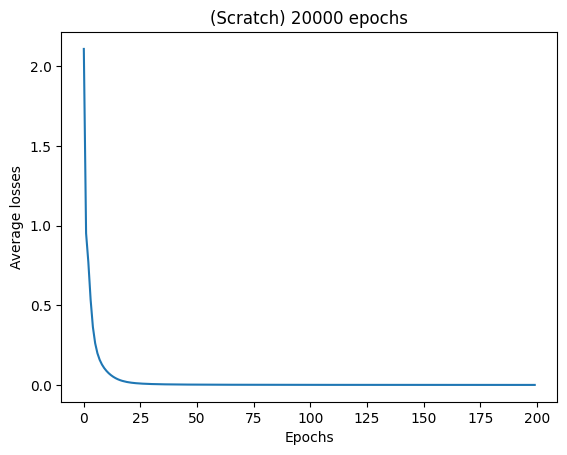

In [29]:
plot_in_visdom(losses, title=f'(Scratch) {epochs} epochs', xlabel='Epochs', ylabel='Losses')

Setting up a new session...


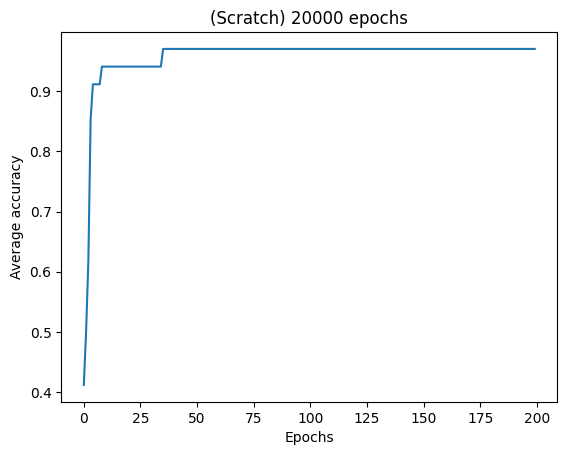

In [30]:
plot_in_visdom(accuracy, title=f'(Scratch) {epochs} epochs', xlabel='Epochs', ylabel='Accuracy')